# Combination of Histograms

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
import sys 
import hickle

sys.path.insert(0, '../energy_calibration/rebin/')
import rebin as rb
import DPXhistSupport as dhs

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

## Important constants

In [2]:
NEntries = 100000
NHists = 2
mu = 60
sigma = 5
PLOT_DIR = 'publish/'

## Generate bin edges

In [3]:
def getBinEdgesRandom(NPixels, edgeMin, edgeMax, edgeOvfw, uniform=False, paramDict=None):
    edgeList = []
    for pixel in range(NPixels):
        if uniform:
            # Calculate bin edges
            binEdges = np.sort(np.random.uniform(edgeMin, edgeMax, 15))
            binEdges = np.insert(binEdges, 0, edgeMin)
            binEdges = np.append(binEdges, edgeOvfw)
        else:
            pixelOffset = 2
            if paramDict is not None:
                while pixel + pixelOffset not in paramDict.keys():
                    pixelOffset += 4
                params = paramDict[pixel + pixelOffset]

                a, b, c, t = params['a'], params['b'], params['c'], params['t']
                if 'h' in params.keys():
                    h, k = params['h'], params['k']
                else:
                    h, k = 1, 0

                # print( a, b, c, t, h, k )
                # Get min, max and overflow edges
                edgeMin_ = EnergyToToTSimple(edgeMin, a, b, c, t, h, k)
                edgeMax_ = EnergyToToTSimple(edgeMax, a, b, c, t, h, k)
                edgeOvfw_ = EnergyToToTSimple(edgeOvfw, a, b, c, t, h, k)
                if edgeMin_ > edgeMax_:
                    edgeMin_, edgeMax_ = edgeMax_, edgeMin_
                # print (edgeMin_, edgeMax_, edgeOvfw_)

                # Get bin edges with noisy evenly spaced distances
                binEdges = np.around(getBinEdgesRandomEvenSpace(edgeMin_, edgeMax_, edgeOvfw_))

                # Convert back to energy
                binEdges = ToTtoEnergySimple(np.asarray(binEdges), a, b, c, t, h, k)
                if any(np.isnan(binEdges)):
                    binEdges = getBinEdgesRandomEvenSpace(edgeMin, edgeMax, edgeOvfw)
                # print( binEdges )
                # print

            else:
                binEdges = getBinEdgesRandomEvenSpace(edgeMin, edgeMax, edgeOvfw)

        edgeList.append( binEdges )
    return edgeList

def getBinEdgesRandomEvenSpace(edgeMin, edgeMax, edgeOvfw):
    # Mean difference 
    diff = float(edgeMax - edgeMin) / 15
    binDiff = np.random.normal(diff, diff / 3., 15)
    binDiff -= (np.sum(binDiff) - (edgeMax - edgeMin)) / 15
    binEdges = np.cumsum(binDiff) + edgeMin
    binEdges = np.insert(binEdges, 0, 1.5 * edgeMin + abs(np.random.normal(0, 0.5*diff)))
    binEdges = np.append(binEdges, edgeOvfw)
    binEdges = np.sort( binEdges )

    return binEdges

def getBinEdgesUniform(NPixels, edgeMin, edgeMax, edgeOvfw):
    edgeList = []
    xInit = np.linspace(edgeMin, edgeMax, 16)
    bw = xInit[1] - xInit[0]
    pixelIdx = 0
    for pixel in range(NPixels):
        if pixel % 16 in [0, 1, 14, 15]:
            edgeList.append(np.append(xInit, edgeOvfw))
            continue

        offset = bw / 192. * pixelIdx
        edgeList.append(np.append(xInit + offset, edgeOvfw))
        pixelIdx += 1
    return edgeList

# Conversion functions
# Energy to ToT and vice versa
def ToTtoEnergySimple(x, a, b, c, t, h=1, k=0):
    return h * (b + 1./(4 * a) * (2*x + np.pi*c + np.sqrt(16 * a * c * t + (2 * x + np.pi * c)**2))) + k

def EnergyToToTSimple(x, a, b, c, t, h=1, k=0):
    res = np.where(x < b, a*((x - k)/h - b) - c * (np.pi / 2 + t / ((x - k)/h - b)), 0)
    res[res < 0] = 0
    return res

## Load Parameter Dictionary
Load energy calibration parameters from file if needed

In [4]:
paramsDict = hickle.load('paramsDict_DPX22.hck')

## Uniform vs. width distribution
Get the distance between two neighbouring bin edges and show their distribution. Two methods are compared:
- Uniform distribution of edges within specified range and succeeding reordering of the bins
- Width distribution where a normal distribution is used to sample random numbers with a mean value of `(edgeMax - edgeMin) / 15`

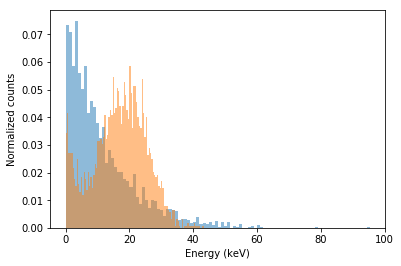

In [5]:
# Uniform
binEdgesUniform = getBinEdgesRandom(NPixels=192, edgeMin=12, edgeMax=200, edgeOvfw=430, uniform=True, paramDict=None)

# Width distribution
binEdgesWidth = getBinEdgesRandom(NPixels=192, edgeMin=12, edgeMax=270, edgeOvfw=430, uniform=False, paramDict=paramsDict)

diffListUniform, diffListWidth = [], []
for idx in range(len(binEdgesWidth)):
    diffListUniform += list(np.diff(binEdgesUniform[idx])[:-1])
    diffListWidth += list(np.diff(binEdgesWidth[idx])[:-1])

diffListWidth = np.asarray(diffListWidth)
diffListWidth = diffListWidth[~np.isnan(diffListWidth)]
histOut = plt.hist(diffListUniform, bins=100, density=True, alpha=.5)
histOut = plt.hist(diffListWidth, bins=100, density=True, alpha=.5)
plt.xlabel('Energy (keV)')
plt.ylabel('Normalized counts')
plt.savefig('binWidthDistUniform.svg')

## Non-random bin edges

In [6]:
isLarge = [pixel % 16 not in [0, 1, 14, 15] for pixel in range(256)]
binEdgesUniform = np.asarray(getBinEdgesUniform(256, 12, 100, 430))[isLarge]
binEdgesUniform = binEdgesUniform.T[:-1].T

## Sample events
Get random events

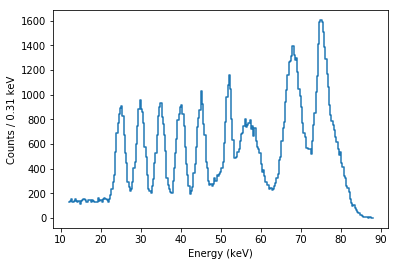

In [8]:
muList = [25, 30, 35, 40, 45, 50, 52, 57, 68, 75, 77]
stdList = [1., 1., 1., 1., 1., 2, .7, 2.5, 2, 1, 3]
intensity = [1., 1., 1., 1., 1., .5, .7, 2., 3, 1, 3]

def getNormalHist(mu, std, intensity, Nevents):
    data = []

    # Normalize intensity if needed
    if np.sum(intensity) != 1.:
        intensity = np.asarray(intensity) / np.sum(intensity)

    for idx, mu_ in enumerate(mu):
        sigma = std[idx]
        N = Nevents * intensity[idx]
        data += list( np.random.normal(mu_, sigma, int(N + np.random.choice([-1, 1]) * np.sqrt(N))) )

    data += list(np.random.uniform(12, max(mu), int(0.3 * Nevents)))
    return data

dataNormal = getNormalHist(muList, stdList, intensity, NEntries)
# dataNormal = [100]*NEntries
histInit, binsInit = np.histogram(dataNormal, bins=250)
plt.step(binsInit[:-1], histInit, where='post')
plt.xlabel('Energy (keV)')
plt.ylabel('Counts / %.2f keV' % (binsInit[1] - binsInit[0]))
plt.savefig(PLOT_DIR + 'random_data.svg')

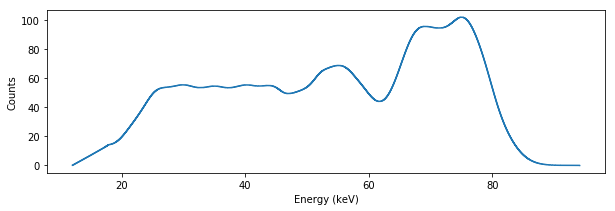

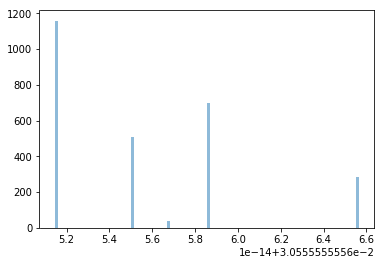

In [9]:
def getRebinedHist(binEdges, data, plot=False):
    bins, hist = dhs.rebinEnergyHist(binEdges, data, NPixel=192, plot=False)
    bins, hist = np.asarray(bins), np.asarray(hist)
    binsLast = bins[-1]
    bins = bins[:-1][hist > 0]
    bins = np.append(bins, binsLast)
    hist = hist[hist > 0]
    
    if plot:
        fig, ax = plt.subplots(figsize=(10, 3))
        ax.step(bins[:-1], hist, where='post')
        ax.set_xlabel('Energy (keV)')
        ax.set_ylabel('Counts')
        plt.show()

    return bins, hist

binsUniform, histUniform = getRebinedHist(binEdgesUniform, dataNormal, plot=True)
diffUniform = np.diff(binsUniform)[:-1]
diffUniform = diffUniform[diffUniform < 0.5]
histOut = plt.hist(diffUniform, bins=100, alpha=.5, label='Uniform')
plt.show()

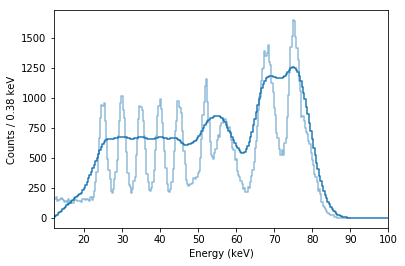

In [129]:
xUniform = np.linspace(min(binsUniform), max(binsUniform), 250)
yUniform = np.nan_to_num(rb.rebin(binsUniform, histUniform, xUniform, interp_kind='piecewise_constant'))
# yUniform = scipy.signal.savgol_filter(yUniform, 31, 3)

plt.step(binsInit[:-1], histInit, where='post', color='C0', alpha=.5)
plt.step(xUniform[:-1], yUniform, where='post', label='Uniform')
plt.xlim(12, 100)
# plt.ylim(0, 2200)

plt.xlabel('Energy (keV)')
plt.ylabel('Counts / %.2f keV' % (xUniform[1] - xUniform[0]))
plt.savefig(PLOT_DIR + 'uniform_convolution.svg')
plt.show()

## Generate histograms

In [118]:
def genHist(NEntries, NHists, edges=(12, 236, 430), mu=[60], std=[3], intensity=[1]):
    binsList, histList = [], []
    dataList = []

    for i in range(NHists):
        # Calculate bin edges
        binEdges = np.sort(np.random.uniform(edges[0], edges[1], 15))
        binEdges = np.insert(binEdges, 0, edges[0])
        binEdges = np.append(binEdges, edges[2])

        # Generate (or load) random data
        data = []
        for idx, mu_ in enumerate(mu):
            sigma = std[idx]
            N = NEntries * intensity[idx]
            data += list( np.random.normal(mu_, sigma, int(N + np.random.choice([-1, 1]) * np.sqrt(N))) )

        data = np.asarray( data )
        data = data[data > 0]
        dataList += list( data )

        # Calculate histogram
        hist, bins = np.histogram(data, bins=binEdges, density=True)
        histList.append( hist ), binsList.append( bins )

    binsNew = np.sort(np.hstack(binsList))
    histNewList = []

    for i in range(NHists):
        bins, hist = binsList[i], histList[i]

        h = np.zeros(len(binsNew) - 1)
        for j in range(len(bins) - 1):
            b1, b2 = bins[j:j+2]
            h[np.logical_and(binsNew[:-1] >= b1, binsNew[:-1] < b2)] = hist[j]
            
        # Last bin
        b1 = bins[-2]
        h[binsNew[:-1] >= b1] = hist[-1]
        histNewList.append( h )

    histNew = 1./NHists * np.sum(histNewList, axis=0)
    plt.step(binsNew[:-1], histNew / float(max(histNew)), where='post')

    # Plot
    # plt.hist(np.asarray(dataList).flatten(), bins=100)
    hist, bins = np.histogram(dataList, bins=100)
    plt.step(bins[:-1], hist / float(max(hist)), where='post')
    
    return binsNew, histNew

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT0xLCBkZXNjcmlwdGlvbj11J3gnLCBtYXg9MTkyLCBtaW49MSksIE91dHB1dCgpKSwgX2RvbV9jbGFzc2VzPSh1J3dpZGdldC3igKY=


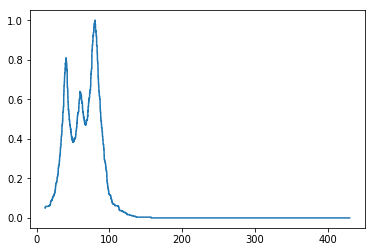

In [42]:
interact(lambda x: genHist(NEntries, x, (12, 236, 430), mu=[40, 60, 80], std=[1.5, 2., 2.1], intensity=[0.3, 0.2, 0.5]), x=widgets.IntSlider(min=1,max=192,step=1,value=1));

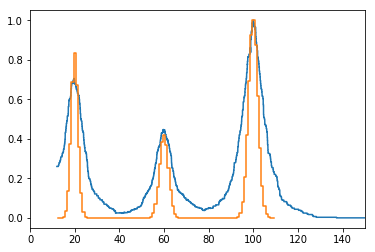

In [19]:
bins, hist = genHist(NEntries, 100, (12, 140, 430), mu=[20, 60, 100], std=[1.5, 2., 2.1], intensity=[0.3, 0.2, 0.5])
plt.xlim(0, 150)
plt.show()
# f = scipy.interpolate.interp1d(bins[:-1], hist)
# x = np.linspace(12, 430, 1000)
# plt.plot(x, f(x))
# plt.xlim(0, 150)

## Deconvolution functions

In [119]:
def wiener_deconvolution(signal, kernel, lambd):
    "lambd is the SNR"
    kernel = np.hstack((kernel, np.zeros(len(signal) - len(kernel)))) # zero pad the kernel to same length
    H = np.fft.fft(kernel)
    deconvolved = np.real(np.fft.ifft(np.fft.fft(signal)*np.conj(H)/(H*np.conj(H) + lambd**2)))
    return deconvolved

def water_level_decon(y_meas, window, eps=0.1):
    padded = np.zeros_like(y_meas)
    padded[:window.size] = window

    yfreq = np.fft.fft(y_meas)
    winfreq = np.fft.fft(padded)

    winfreq[winfreq < eps] = eps
    newfreq = yfreq / winfreq 

    return np.fft.ifft(newfreq)

## Estimate window size

((628.2726779513832, 20, 5), array([641.96247104,  19.80065766,   5.86803755]))
((631.0456090856507, 40, 5), array([642.13974413,  39.81600759,   5.87030315]))
((631.30146846065, 60, 5), array([641.98884456,  59.79874589,   5.87035943]))
5.8695667138713175


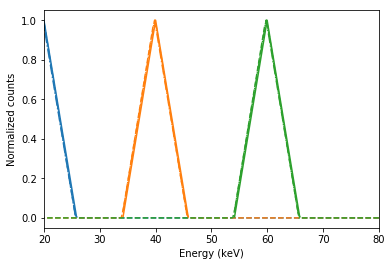

In [130]:
windowTau = dhs.estimateWindow(xUniform, binEdgesUniform, dhs.triangleWindow, meanRange=np.arange(20, 100 - 20, 20), plot=True)

12.0
12.0 105.83611111111111 250


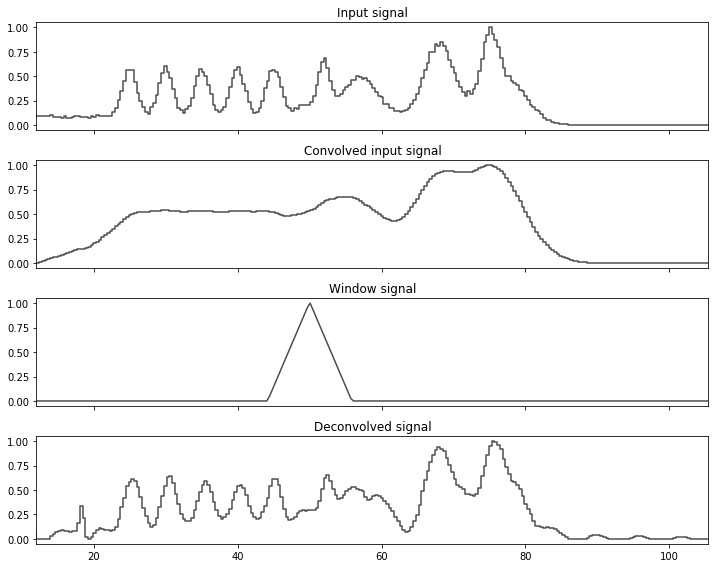

In [145]:
import scipy.signal

# def showDeconvolution(data, ):
# Create figure
fig, ax = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
flatEdges = np.asarray(xUniform).T[:-1].flatten()
minE, maxE = min(flatEdges), max(flatEdges)

# Input signal
histNormal, binsNormal = np.histogram(dataNormal, bins=xUniform)
print(min(binsNormal))
ax[0].step(binsNormal[:-1], histNormal/float(np.max(histNormal)), where='post', color='k', alpha=.7)
ax[0].set_xlim(minE, maxE)

# Measured signal
hist = yUniform
bins = xUniform

# Zero padding
padFront, padBack = 1000, 1000
hist = np.pad(hist, (padFront, padBack), 'constant', constant_values=(hist[0], 0))

# Get window function
xWindowMax = 100
lambd = .05

xWindow = np.linspace(minE, maxE, len(bins[:-1])) 
yWindow = np.asarray(dhs.triangleWindow(xWindow, 1, .5*xWindowMax, windowTau))
yWindow = 1 * yWindow / float(max(yWindow))
print(min(bins), max(bins), len(bins))

ax[2].plot(xWindow, yWindow, color='k', alpha=.7)
ax[1].step(bins[:-1], hist[padFront:-padBack] / max(hist), where='post', color='k', alpha=.7)

ax[1].set_xlim(minE, maxE)
ax[2].set_xlim(minE, maxE)
# plt.show()

deconv = dhs.wiener_deconvolution(hist, yWindow, lambd=lambd)
deconv[deconv < 0] = 0
deconv = np.asarray(list(deconv[-100//2:]) + list(deconv[:-100//2]))
shift = 53
ax[3].step(bins[:-1], deconv[padFront-shift:-padBack-shift] / max(deconv), color='k', alpha=.7)
ax[3].set_xlim(minE, maxE)

ax[0].set_title('Input signal')
ax[1].set_title('Convolved input signal')
ax[2].set_title('Window signal')
ax[3].set_title('Deconvolved signal')
plt.tight_layout()
plt.savefig(PLOT_DIR + 'demo_deconvolution.svg')
plt.show()

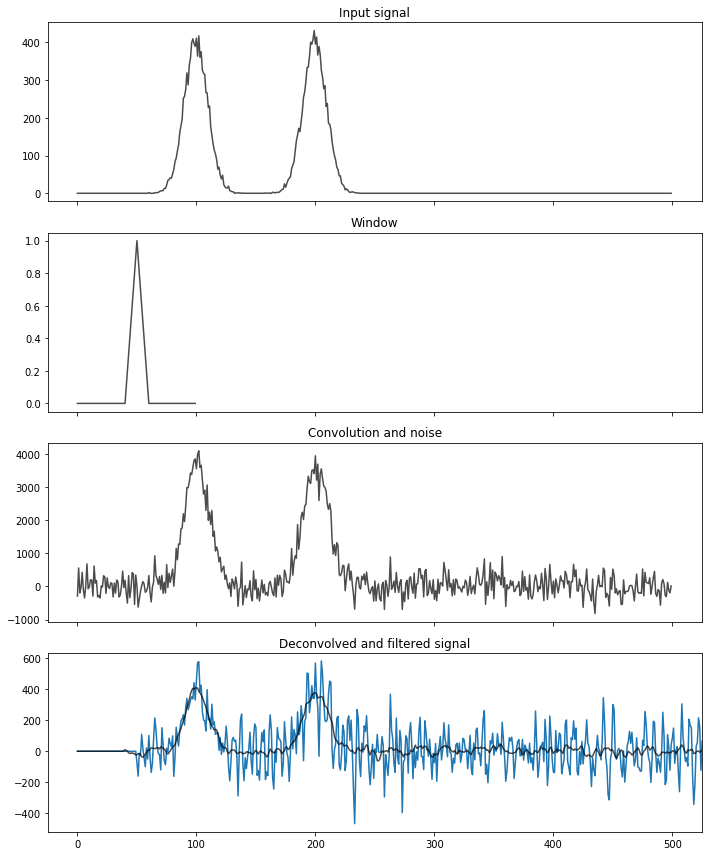

In [152]:
x = np.arange(500)

fig, ax = plt.subplots(4, 1, figsize=(10, 12), sharex=True)
# Input signal
# signal = np.zeros(len(x))
# signal[100], signal[200], signal[300], signal[400] = 1, 1, 1, 1
signal1, bins = np.histogram(np.random.normal(100, 10, 10000), bins=np.arange(501))
signal2, bins = np.histogram(np.random.normal(200, 10, 10000), bins=np.arange(501))
signal = signal1 + signal2

ax[0].plot(x, signal, color='k', alpha=.7)
ax[0].set_title('Input signal')

# expWindow-filter
filt = dhs.triangleWindow(np.arange(100), 1, 50, 10)
ax[1].plot(filt, color='k', alpha=.7)
ax[1].set_xlim(-25, 525)
ax[1].set_title('Window')

# Convolution
signal_conv = np.convolve(signal, filt, mode='same')
# Add noise
signal_conv += np.random.normal(0, 300, len(signal_conv))
ax[2].plot(signal_conv, color='k', alpha=.7)
ax[2].set_title('Convolution and noise')

# signal_conv = scipy.signal.savgol_filter(signal_conv, 23, 3)
# ax[2].plot(signal_conv)
# signal_conv = water_level_decon(signal_conv, filt)

# Deconvolution
signal_conv = wiener_deconvolution(signal_conv, filt, lambd=0.5)
signal_conv = list(np.zeros(50)) + list(signal_conv)
ax[3].plot(signal_conv)
signal_conv = scipy.signal.savgol_filter(signal_conv, 23, 3)
ax[3].plot(signal_conv, color='k', alpha=.7)
ax[3].set_title('Deconvolved and filtered signal')

plt.tight_layout()
plt.show()

## Data

In [16]:
import hickle as hck
sys.path.insert(0, '../dpx_func/dpx_func_python/dpx_func_python')
import plotTemperatureToT as pttt
import ToTtoEnergy as tte
import DPXhistSupport as dhs
reload(pttt)
reload(tte)

# dataDir = '../dpx_func/dpx_data/'
dataDir = './pileUp/doseMeasurement_pileUpCorr_240_300keV/'

# doseFile = 'doseMeasurement_AmRandom_v2_2.hck'
# doseFile = 'doseMeasurement_28.hck'
# doseFile = 'doseDennisBins/doseDennis_uniformShiftBins/doseMeasurement.hck'
doseFile = 'doseMeasurement.hck'

tempFile = 'doseMeasurementTemp_AmRandom_v2_2.hck'
# paramsDictFile = '../dpx_func/dpx_data/energyConversion/paramsDict_DPX22_6_109.hck'
paramsDictFile = 'doseDennisBins/paramsDict_Dennis2.hck'

# binEdgesFile = '../dpx_func/dpx_data/binEdgesRandom_DPX22_6_109_v2.hck'
# binEdgesFile = '../dpx_func/dpx_data/binEdgesRandom_DPX22_6_109_v2.hck'
# binEdgesFile = 'doseDennisBins/doseDennis_uniformShiftBins/binEdgesUniform_Dennis.hck'
binEdgesFile = 'binEdgesUniform_Dennis.hck'

tempCalibFile = '../dpx_func/dpx_func_python/dpx_func_python/tempCalib_DPX22.hck'

In [192]:
# Load files
doseDict = hck.load(dataDir + doseFile)
tempDict = None # hck.load(dataDir + tempFile)
binEdgesRandomDict = hck.load(dataDir + binEdgesFile)
tempCalibDict = None # hck.load(tempCalibFile)
paramsDict = hck.load(paramsDictFile)

## Temperature Correction

In [58]:
slot = 1
if tempDict is not None:
    binEdgesCorrDict = dhs.correctTemperature(binEdgesRandomDict, tempDict, tempCalibDict, slot=1)
else: 
    binEdgesCorrDict = binEdgesRandomDict

TypeError: 'NoneType' object has no attribute '__getitem__'

In [75]:
print(paramsDict.keys())
print(T, tempCalibDict['Toffset'])
print(binEdgesRandomDict['Slot%d' % slot][4])
print(binEdgesCorrDict['Slot%d' % slot][4])

['Slot1', 'Slot3', 'Slot2']


NameError: name 'T' is not defined

In [76]:
plt.plot(tempDict['time'], tempDict['temp'], marker='x')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (DAC)')

TypeError: 'NoneType' object has no attribute '__getitem__'

In [122]:
binEdgesCorrDict['Slot%d' % slot]

[array([ 12.        ,  32.53333333,  53.06666667,  73.6       ,
         94.13333333, 114.66666667, 135.2       , 155.73333333,
        176.26666667, 196.8       , 217.33333333, 237.86666667,
        258.4       , 278.93333333, 299.46666667, 320.        ,
        430.        ]),
 array([ 12.        ,  32.53333333,  53.06666667,  73.6       ,
         94.13333333, 114.66666667, 135.2       , 155.73333333,
        176.26666667, 196.8       , 217.33333333, 237.86666667,
        258.4       , 278.93333333, 299.46666667, 320.        ,
        430.        ]),
 array([ 12.        ,  32.53333333,  53.06666667,  73.6       ,
         94.13333333, 114.66666667, 135.2       , 155.73333333,
        176.26666667, 196.8       , 217.33333333, 237.86666667,
        258.4       , 278.93333333, 299.46666667, 320.        ,
        430.        ]),
 array([ 11.89305556,  32.42638889,  52.95972222,  73.49305556,
         94.02638889, 114.55972222, 135.09305556, 155.62638889,
        176.15972222, 196.693055

### Distribution of binEdges

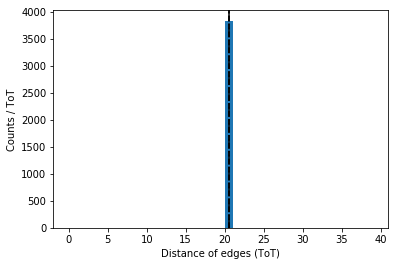

In [130]:
slot = 1
diff = np.diff(binEdgesCorrDict['Slot%d' % slot]).T[:-1].flatten()
_ = plt.hist(diff , bins=np.arange(40) )
plt.axvline(x=np.mean(diff), ls='-.', color='k')
plt.axvline(x=np.mean(diff) - np.std(diff), ls='--', color='k')
plt.axvline(x=np.mean(diff) + np.std(diff), ls='--', color='k')

plt.xlabel('Distance of edges (ToT)')
plt.ylabel('Counts / ToT')
plt.show()

### Binning of large pixels

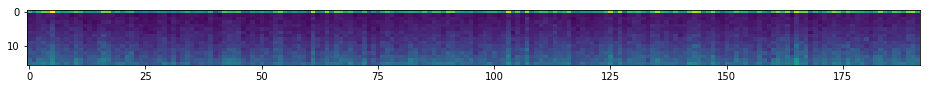

In [194]:
fig, ax = plt.subplots(1, figsize=(16, 1))
largePixels = np.asarray([pixel for pixel in np.arange(256) if pixel % 16 not in [0, 1, 14, 15]])
ax.imshow( np.reshape(np.sum(doseDict['Slot%d' % slot], axis=0), (256, -1))[largePixels].T[-16:], aspect='auto' )

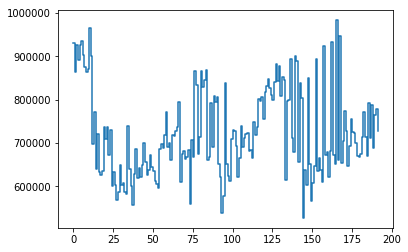

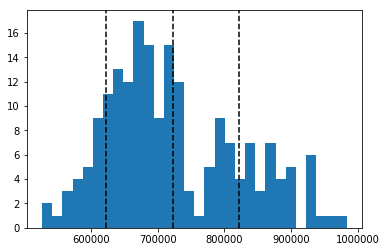

In [135]:
d = np.sum(np.reshape(np.sum(doseDict['Slot%d' % slot], axis=0), (256, -1))[largePixels].T[-12:], axis=0)
# d = np.sum(np.reshape(doseDict['Slot1'][-1], (256, -1))[largePixels].T[-12:], axis=0)
plt.step(np.arange(len(d)), d, where='post')
plt.show()
plt.hist(d, bins=30)
plt.axvline(x=np.mean(d), ls='--', color='k')
plt.axvline(x=np.mean(d) + np.std(d), ls='--', color='k')
plt.axvline(x=np.mean(d) - np.std(d), ls='--', color='k')

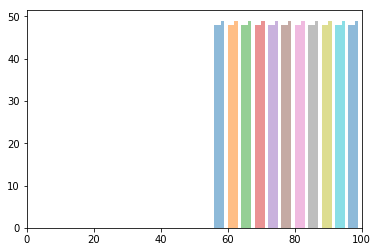

In [168]:
for i in range(12):
    data = np.asarray(binEdgesCorrDict['Slot%d' % slot]).T[i]
    plt.hist(data, bins=np.arange(min(data), max(data)), alpha=.5)
plt.xlim(0, 100)
plt.show()

### Pixel Level Analysis

In [66]:
def showPixel(doseDict, binEdges, idx=0):
    hist = np.reshape( np.sum(np.asarray(doseDict), axis=0), (256, -1) )[idx]
    plt.step(binEdges[idx][:-1], np.flip(hist, axis=0), where='post')
    
    plt.xlim(12, 100)
    # plt.ylim(top=10000)
    pixelType = 'small' if idx % 16 in [0, 1, 14, 15] else 'large'
    plt.title('Pixel %d (%s), Cts = %d' % (idx, pixelType, np.sum(hist)))
    plt.xlabel('Energy (keV)')
    plt.ylabel('Counts per bin')

In [16]:
_ = widgets.interact(showPixel, doseDict=doseDict, binEdges=binEdgesCorrDict, idx=widgets.IntSlider(value=0, min=0, max=32, step=1, interval=500))

aW50ZXJhY3RpdmUoY2hpbGRyZW49KERyb3Bkb3duKGRlc2NyaXB0aW9uPXUnZG9zZURpY3QnLCBvcHRpb25zPXsnU2xvdDEnOiBbYXJyYXkoW1tbMC4sIDAuLCAwLiwgLi4uLCAxLiwgMS4sIDDigKY=


In [67]:
print(binEdgesRandomDict['Slot1'][7])

[41.6   41.6   41.6   41.625 41.65  41.675 41.7   41.725 41.75  41.775
 41.8   41.825 41.85  41.875 41.6   41.6   41.6   41.6   41.9   41.925
 41.95  41.975 42.    42.025 42.05  42.075 42.1   42.125 42.15  42.175
 41.6   41.6   41.6   41.6   42.2   42.225 42.25  42.275 42.3   42.325
 42.35  42.375 42.4   42.425 42.45  42.475 41.6   41.6   41.6   41.6
 42.5   42.525 42.55  42.575 42.6   42.625 42.65  42.675 42.7   42.725
 42.75  42.775 41.6   41.6   41.6   41.6   42.8   42.825 42.85  42.875
 42.9   42.925 42.95  42.975 43.    43.025 43.05  43.075 41.6   41.6
 41.6   41.6   43.1   43.125 43.15  43.175 43.2   43.225 43.25  43.275
 43.3   43.325 43.35  43.375 41.6   41.6   41.6   41.6   43.4   43.425
 43.45  43.475 43.5   43.525 43.55  43.575 43.6   43.625 43.65  43.675
 41.6   41.6   41.6   41.6   43.7   43.725 43.75  43.775 43.8   43.825
 43.85  43.875 43.9   43.925 43.95  43.975 41.6   41.6   41.6   41.6
 44.    44.025 44.05  44.075 44.1   44.125 44.15  44.175 44.2   44.225
 44.25  44.2

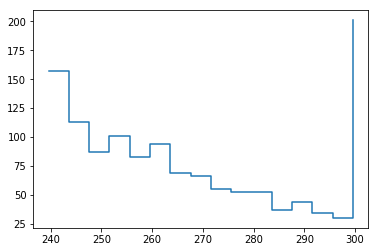

In [195]:
idx = 26
dose = np.reshape( np.sum(np.asarray(doseDict['Slot%d' % slot]), axis=0), (256, -1) )
plt.step(binEdgesRandomDict['Slot%d' % slot][idx][:-1], np.flip(dose[idx], axis=0), where='post')
# plt.xlim(10, 70)

In [69]:
def ToTtoEnergySimple(x, a, b, c, t, h=1, k=0):
    return h * (b + 1./(4 * a) * (2*x + np.pi*c + np.sqrt(16 * a * c * t + (2 * x + np.pi * c)**2))) + k

def EnergyToToTSimple(x, a, b, c, t, h=1, k=0):
    res = np.where(x < b, a*((x - k)/h - b) - c * (np.pi / 2 + t / ((x - k)/h - b)), 0)
    idx = np.argwhere(res <= 0)

    if list(idx):
        res[np.arange(idx[-1]+1)] = 0
        # res[res < 0] = 0
    return res

p = paramsDict[7]
x = np.linspace(0, 100, 1000)
xRand = binEdgesRandomDict['Slot%d' % slot][7]
plt.plot(x, EnergyToToTSimple(x, p['a'], p['b'], p['c'], p['t'], p['h'], p['k']))
plt.plot(xRand, np.floor(EnergyToToTSimple(xRand, p['a'], p['b'], p['c'], p['t'], p['h'], p['k'])), marker='+', ls='', markersize=15, color='k')
plt.xlim(0, 100)
plt.ylim(100, 400)

print(xRand)
print( np.floor(EnergyToToTSimple(xRand, p['a'], p['b'], p['c'], p['t'], p['h'], p['k'])) )
print( ToTtoEnergySimple(np.floor(EnergyToToTSimple(xRand, p['a'], p['b'], p['c'], p['t'], p['h'], p['k'])), p['a'], p['b'], p['c'], p['t'], p['h'], p['k']) )

KeyError: 7

### Filtering

In [196]:
binEdgesNew = []
doseNew = []
for idx, d in enumerate(np.flip(dose, axis=1)):
    be = binEdgesCorrDict['Slot%d' % slot][idx]
    # print( be[np.argwhere(be[:-1] > 65).flatten()] )
    print( np.sum(d[np.argwhere(be[:-1] > 95).flatten()]) )

    if True: # np.sum(d[np.argwhere(be[:-1] > 95).flatten()]) < 100:
        binEdgesNew.append( be )
        doseNew.append(d)

0.0
0.0
1461.0
1288.0
1580.0
1678.0
1622.0
2098.0
1458.0
1347.0
1423.0
1311.0
1718.0
1525.0
0.0
0.0
0.0
0.0
1125.0
1243.0
1226.0
1461.0
1756.0
1611.0
1251.0
1377.0
1275.0
1392.0
1526.0
1152.0
0.0
0.0
0.0
0.0
1112.0
1138.0
1026.0
1105.0
1320.0
1364.0
1064.0
1376.0
1020.0
1259.0
1457.0
1221.0
0.0
0.0
0.0
0.0
1180.0
1228.0
1158.0
1462.0
965.0
1125.0
1529.0
1604.0
1557.0
1565.0
1073.0
1008.0
0.0
0.0
0.0
0.0
1317.0
1162.0
1390.0
1177.0
1171.0
1601.0
1674.0
1216.0
1170.0
1267.0
1327.0
1211.0
0.0
0.0
0.0
0.0
986.0
1832.0
1183.0
1202.0
1657.0
1275.0
1655.0
1556.0
1414.0
1588.0
1230.0
1192.0
0.0
0.0
0.0
0.0
1575.0
944.0
1248.0
977.0
1364.0
1557.0
1428.0
1187.0
1314.0
1313.0
1546.0
1479.0
0.0
0.0
0.0
0.0
1282.0
1459.0
1349.0
1561.0
1478.0
1314.0
1648.0
1619.0
1418.0
1423.0
1347.0
1466.0
0.0
0.0
0.0
0.0
1083.0
1272.0
1406.0
1395.0
1311.0
1230.0
1311.0
1948.0
1143.0
1551.0
1226.0
1891.0
0.0
0.0
0.0
0.0
1119.0
1344.0
1525.0
1485.0
1337.0
1610.0
1410.0
1475.0
1658.0
1068.0
1161.0
1323.0
0.0
0.0
0.0


### Rebinning

Text(0.5,0,'Energy (keV)')

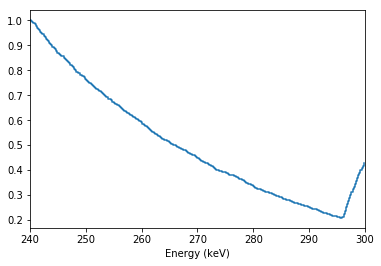

In [198]:
# binsNew, histNew = rebinEnergyData(binEdgesRandomDict['Slot1'], np.flip(dose, axis=1))
binsNew, histNew = rebinEnergyData(binEdgesNew, doseNew)
xNew = np.linspace(240, 300, 300)
yNew = np.nan_to_num(rb.rebin(binsNew, histNew, xNew, interp_kind='piecewise_constant'))
# plt.step(np.asarray(binsNew[:-1], dtype=int), histNew, where='post')
plt.step(xNew[:-1], yNew / np.max(yNew), where='post')
plt.xlim(240, 300)
plt.xlabel('Energy (keV)')

### Estimate Window

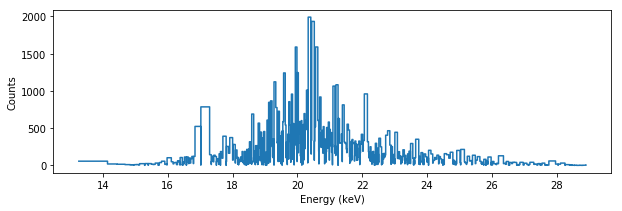

(22632.331783004003, 20, 10) [ 0.23883382 19.66151937  1.46307097]


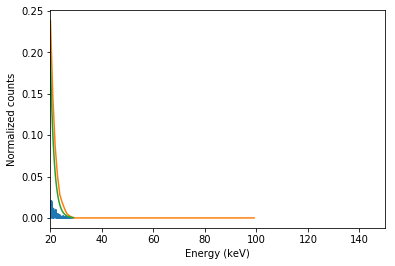

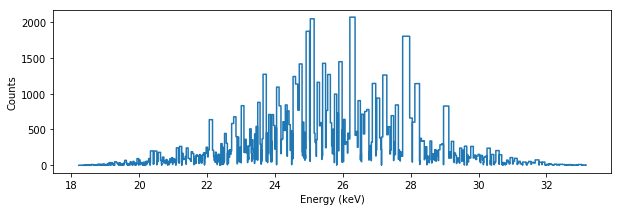

(15897.130302414724, 25, 10) [ 0.15904014 24.76614902  2.6047906 ]


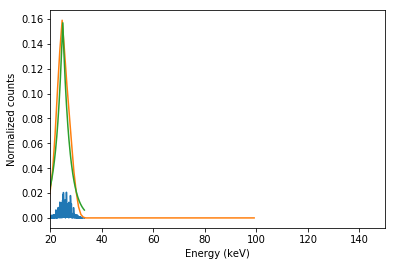

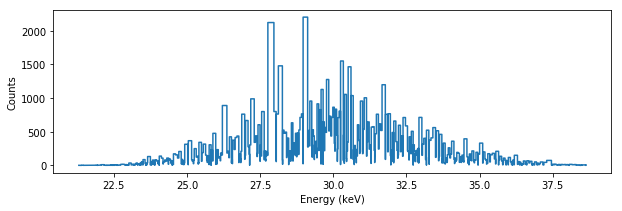

(14414.935560427002, 30, 10) [ 0.14415873 29.48547361  2.75776207]


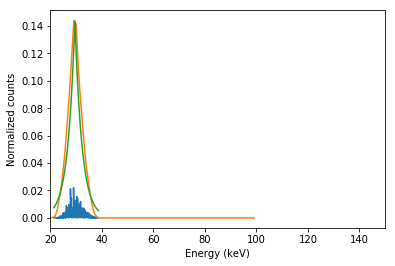

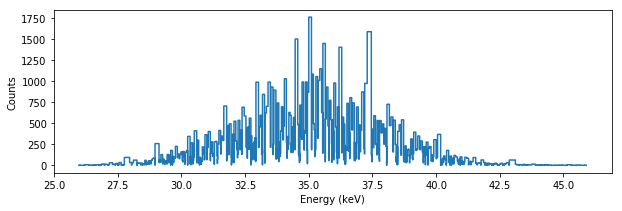

(14580.68953999499, 35, 10) [ 0.14581038 34.53116759  2.97347534]


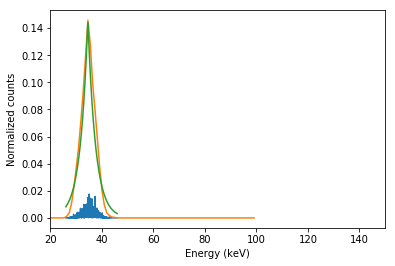

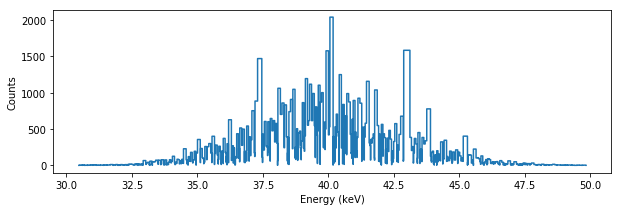

(14336.453623226473, 40, 10) [ 0.14337433 39.44668489  2.77977048]


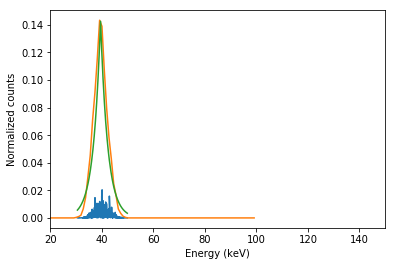

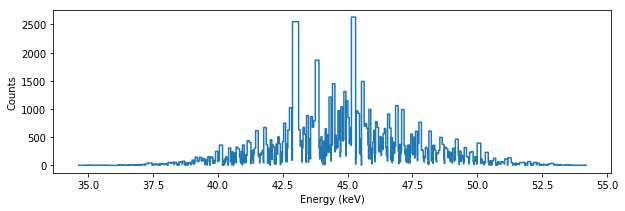

(14841.11114589886, 45, 10) [ 0.14842212 44.37949564  2.80431588]


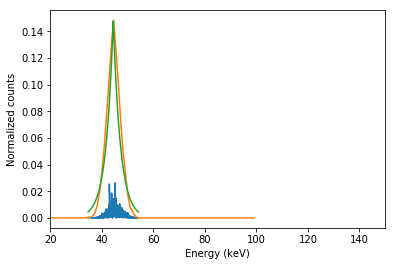

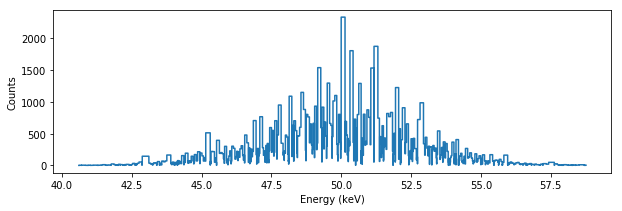

(14426.030929140039, 50, 10) [ 0.1442186  49.58534412  2.73223327]


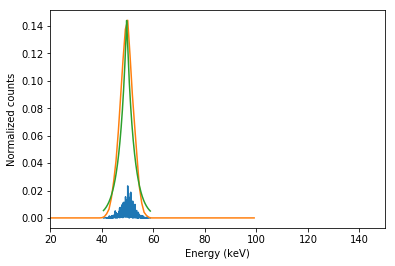

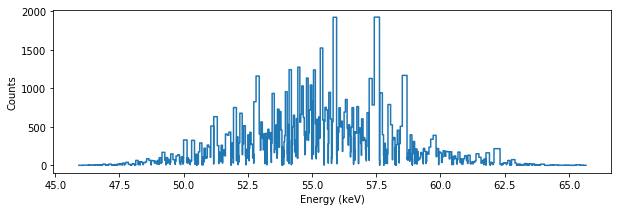

(15350.542123726576, 55, 10) [ 0.15353151 54.74158544  2.73392507]


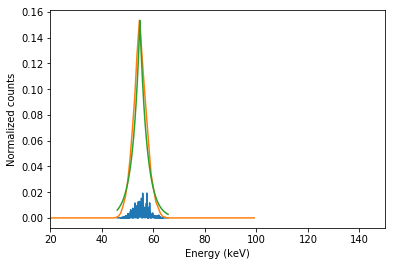

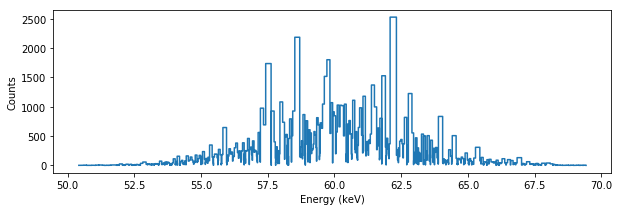

(13900.077163560734, 60, 10) [ 0.13900844 59.57641643  2.81449459]


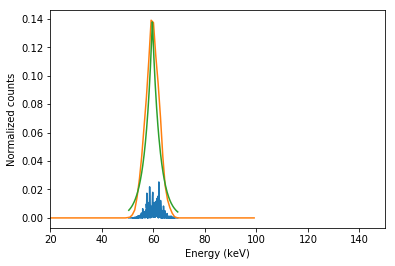

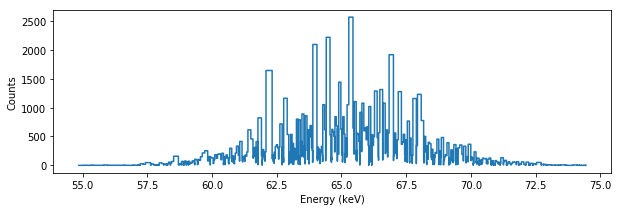

(14909.504752498551, 65, 10) [ 0.1491057  64.78758013  2.78039933]


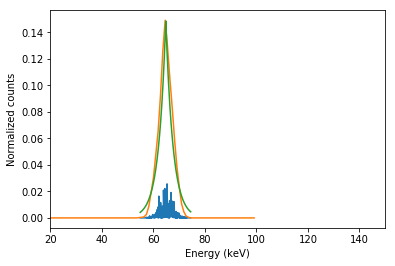

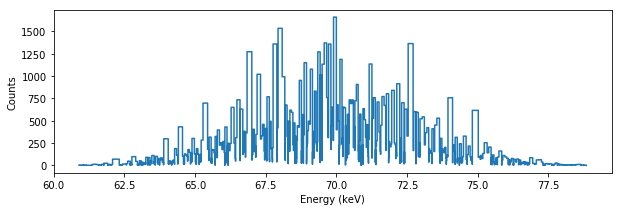

(14220.8787078252, 70, 10) [ 0.1421821  69.42041279  2.84780029]


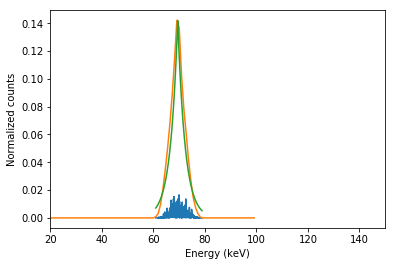

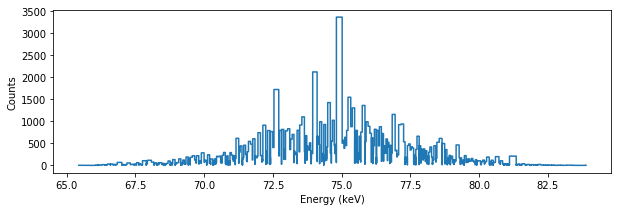

(14252.04278482914, 75, 10) [ 0.14250432 74.39422243  2.9309652 ]


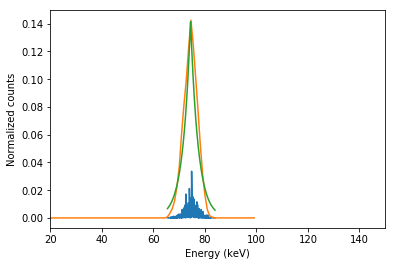

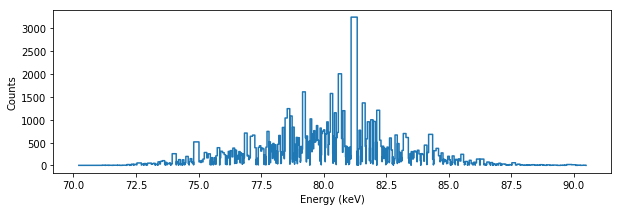

(14838.338351323137, 80, 10) [ 0.14833951 79.59848159  2.62814209]


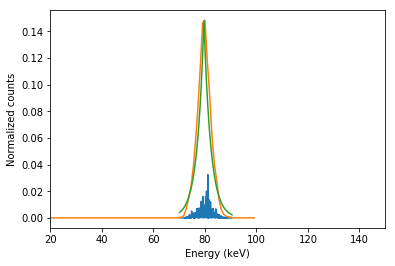

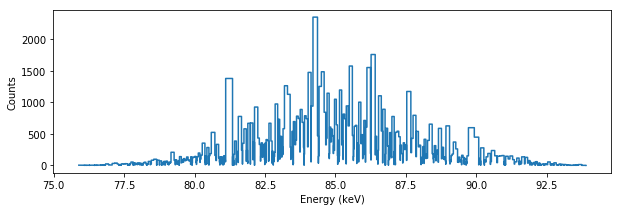

(14237.089651694378, 85, 10) [ 0.14237373 84.32345945  2.86794809]
2.694220947564148


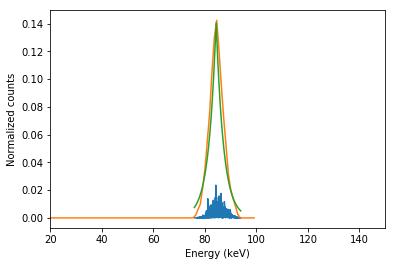

In [24]:
windowTau = estimateWindow(xNew, binEdgesCorrDict['Slot%d' % slot], np.arange(20, 90, 5))

In [188]:
fac = 1
xWindowMax = 100 # * fac
windowTau_ = 1. * windowTau
lambd = .15

xWindow = np.linspace(0, xWindowMax, len(bins[:-1])) 
xWindow = np.arange(0, xWindowMax) # len(hist))
yWindow = np.asarray(expWindow(xWindow, 1, 0.5 * xWindowMax, windowTau_ * fac))
yWindow = 1 * yWindow / float(max(yWindow))

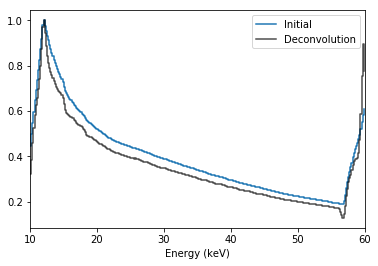

In [190]:
lambd = 1.
padFront, padBack = 1000, 1000
xWindowMax = 100
bins = xNew[:-1]
yWindow = np.asarray(expWindow(xWindow, 1, 0.5 * xWindowMax, windowTau_ * fac))
yWindow = 1 * yWindow / float(max(yWindow))
hist = np.pad(yNew, (padFront, padBack), 'constant', constant_values=(yNew[0], 0))

deconv = wiener_deconvolution(hist, yWindow, lambd=lambd)
deconv[deconv < 0] = 0
deconv = np.asarray(list(deconv[-xWindowMax//2:]) + list(deconv[:-xWindowMax//2]))
plt.step(xNew[:-1], yNew / np.max(yNew), where='post', label='Initial')
plt.step(bins, deconv[padFront:-padBack] / max(deconv), color='k', alpha=.7, label='Deconvolution', where='post')
plt.xlim(10, 60)
plt.xlabel('Energy (keV)')
plt.legend()
plt.savefig('deconv.pdf')
plt.show()